# Question 1 of HWK 5 - Time Correlation

1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936
40960
41984
43008
44032
45056
46080
47104
48128
49152
50176
51200
52224
53248
54272
55296
56320
57344
58368
59392
60416
61440
62464
63488
64512
65536
66560
67584
68608
69632
70656
71680
72704
73728
74752
75776
76800
77824
78848
79872
80896
81920
82944
83968
84992
86016
87040
88064
89088
90112
91136
92160
93184
94208
95232
96256
97280
98304
99328
100352
101376
102400
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936
40960
41984
43008
44032
45056
46080
47104
48128
49152
50176
51200
52224
53248
54272
55296
56320
57344
58368
59392
60416
61440
62464
63488
64512
65536
66560
67584
68608
69632
70656
7

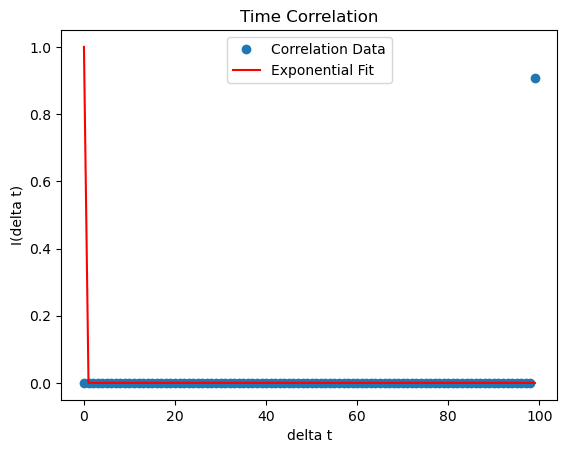

Decorrelation time (τ): 0.10


In [17]:
#References

#[1]https://www.w3schools.com/python/ref_random_seed.asp
#[2]https://stackoverflow.com/questions/66425508/what-is-the-meaning-of-for-in-range
#[3]https://pythoninchemistry.org/sim_and_scat/important_considerations/pbc.html
#[4]https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
#[5]https://github.com/MrFuguDataScience/Python_Basics/blob/main/Python_Profiling.ipynb
#[6]https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb
#[7]https://matplotlib.org/stable/users/explain/animations/animations.html 


#importing libraries
#%pip install line_profiler
#%pip install memory_profiler


import numpy as np
import matplotlib.pyplot as plt
import time
#from line_profiler import LineProfiler
#from memory_profiler import profile
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib.animation as animation


def simulate_ising(L, init_state, T, J, B, N_mc, random_seed=None):
  '''
  A function that takes in a grid size, initial state, Temperature
  J, Monte Carlo steps, and random seed. This builds a 2D Ising model using the
  Metropolis algorithm.

  This function also calculates t_simulate, the time required per MC cycle.
  '''
  np.random.seed(random_seed)

  #First step is to initialize spins of ising grid
  # all_up = +1 , all_down = -1, random = +1 or -1
  if init_state == "all_up":
    state = np.ones((L,L), dtype=np.int8)
  elif init_state == "all_down":
    state = -np.ones((L,L), dtype=np.int8)
  elif init_state == "random":
    state = np.random.choice([-1,1], size=(L, L).astype(np.int8))

  #Initialize trajectory array and time spent per MC cycle array

  beta = 1/T
  

  trajectory = np.zeros((N_mc, L, L))
  time_per_mcmove = np.zeros(N_mc)
  

  for step in range(N_mc):
    t_start = time.time()
  

    #Checkerboard algorithm (grouping black and white grids together)
    for checkerboard in [0, 1]:  # First update "black" cells (i + j is even), then "white" cells (i + j is odd)
      
      indices = np.indices((L,L)) #i and j
      checkerboard_mask = (indices[0]+indices[1]) % 2 == checkerboard 

      neighbor_sum = (np.roll(state, 1, axis=0) + np.roll(state, -1, axis=0) + np.roll(state, 1, axis=1) + np.roll(state, -1, axis=1))
      
      #Calculate energy change
      spin = state[checkerboard_mask]
      neighbor = neighbor_sum[checkerboard_mask]
      dE = (2 * J * spin * neighbor) + (2 * mu_b * B * spin)

      #Metropolis criterion
      flip_mask = (dE < 0) | (np.random.random(spin.shape) < np.exp(-beta * dE))

      state[checkerboard_mask] *= np.where(flip_mask, -1, 1) #If flip is true,then the state gets flipped, if not then it remains the same

    t_end = time.time()
    #expression to calculate the execution time of mc_move
    time_per_mcmove[step] = t_end - t_start
    trajectory[step] = state.copy()
  t_simulate = np.mean(time_per_mcmove) #averages the execution time from the 1500 MC steps

  return trajectory, t_simulate

def plot_state(trajectory, step):
  ising_grid = trajectory[step]

  plt.imshow(ising_grid, cmap='gray') #Purpose of imshow - each site (represented by a square) is denoted by an upspin or downspin [4]
  plt.title(f'Trajectory Plot at Step {step}')
  plt.colorbar(label ='spin')
  plt.show()


def run_simulations(grid_size, T, J, N_mc):
  """
  Calculate t_simulate for each N (LxL)
  """

  times_per_cycle = []
  errors = []

  for L in grid_size:
    _, avg_time_per_cycle = simulate_ising(L, init_state = init_state, T=T, J=J, N_mc = N_mc, random_seed=random_seed)
    times_per_cycle.append(avg_time_per_cycle)

    #Standard error for t_simulate
    std_error = np.std(times_per_cycle) / np.sqrt(len(times_per_cycle))
    errors.append(std_error)

    print(f'System size {L}x{L}: Avg time per MC cycle = {avg_time_per_cycle:.5f} seconds')

  return grid_size, times_per_cycle, errors



def calc_magnetization(trajectory):
  """
  Calculate magnetization for each Ising grid
  """
  magnetization = []
  L = trajectory.shape[1]
  for state in trajectory:
    M = np.sum(state) / (L*L)
    magnetization.append(M)
  return np.array(magnetization)



def run_mag_calc(grid_size, N_mc, J, random_seed=None):
  '''
  #Calculate average magnetization for each N (LxL)

'''

  magnetizations_values = []
  magnetizations_errors = []

  for L in grid_size :
      #Simulate ising at current grid size
      trajectory, _ = simulate_ising(L, init_state, T=T, J=J, B=B, N_mc=N_mc, random_seed=random_seed)
      magnetization_all_steps = calc_magnetization(trajectory)

      #Updating magnetization array by getting rid of first 500 equilibration steps
      updated_magnetization = magnetization_all_steps[500:]

      #Average magnetization and standard deviation at each grid size
      avg_magnetization = np.mean(updated_magnetization)
      std_error = np.std(updated_magnetization) / np.sqrt(1000)

      #Store results
      magnetizations_values.append(avg_magnetization)
      magnetizations_errors.append(std_error)

      print(f'System size {L}x{L}: Magnetization = {avg_magnetization:.5f}')

  return magnetizations_values, magnetizations_errors




def sweep(L, temperatures, N_mc, J, B, random_seed=None):

  #Sweep functions performs the simulate_ising function for the entire
  #temperature range. It then calculates the average magnetization at each temperature that will
  #be needed for one of the plots.


  temperatures=[]
  magnetizations = []

  for T in temperature_range:
      #Simulate ising at current temperature
      trajectory, _ = simulate_ising(L, init_state, T=T, J=J, B=B, N_mc=N_mc, random_seed=random_seed)

      #calculate magnetizations at each temperature
      mags = calc_magnetization(trajectory)
      #print(mags)

      #Average magnetization at current temperature
      avg_magnetization = np.mean(mags)
      #print(avg_magnetization)
      
           #Store results
      temperatures.append(T)
      magnetizations.append(avg_magnetization)

  return np.array(temperatures), np.array(magnetizations)

  

def plot_Mag_vs_Temp(temperatures, magnetizations, init_state, B):
  # Plot Magnetization vs Temperature
  plt.figure(figsize=(12, 5))
  plt.plot(temperatures, magnetizations, marker='o', linestyle='-', label = 'Average Magnetizations')
  plt.title(f'Magnetization vs Temperature at {init_state} and B = {B}')
  plt.xlabel("Temperature")
  plt.ylabel("Magnetization")
  plt.legend()
  plt.tight_layout()
  plt.show()



def plot_Mag_Time_Series(magnetization):
  #Plot Magnetization as Time Series
  plt.plot(magnetization)
  plt.xlabel('Monte Carlo Steps (Time)')
  plt.xlim(0, N_mc)
  plt.ylabel('Magnetization')
  plt.ylim(-1,1)
  plt.title('Magnetization vs MC cycles')
  plt.show()


def plot_tsim_vs_N(L_values, t_sim, tsim_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, t_sim, yerr=tsim_errors, fmt='o', color='r', label='Avg time per MC cycle')
  plt.plot(N_values, t_sim)
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('System Size N = LxL')
  plt.ylabel('t_simulate')
  plt.title('Time per MC cycle vs System Size')
  plt.legend()
  plt.show()


def plot_mag_vs_N(L_values, magnetizations_values, magnetizations_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, magnetizations_values, yerr=magnetizations_errors, fmt='o', color='r')
  plt.plot(N_values, magnetizations_values)
  plt.xlabel('System Size N = LxL')
  plt.ylabel('Magnetizations')
  plt.title('Magnetizations vs System Size')
  plt.show()


#Plotting time block average

def exp_decay(x, t0):
  
  return np.exp(-x / t0)


def plot_time_block_average(trajectory, L, N_mc):

    correlations = np.zeros(N_mc)

    for delta_t in range(N_mc):
      total_corr = 0
      count = 0

      for t in range(N_mc - delta_t):
        total_corr += np.sum(trajectory[t] * trajectory[t + delta_t])
        count += L * L 
        print(count)
    
    correlations[delta_t] = total_corr / count
    print(correlations)

    delta_t_values = np.arange(len(correlations))

    #Fit exponential decay
    params, _ = curve_fit(exp_decay, delta_t_values, correlations)
    tau = params[0]


    plt.plot(delta_t_values, correlations, 'o', label = 'Correlation Data')
    plt.plot(delta_t_values, exp_decay(delta_t_values, tau), 'r-', label = 'Exponential Fit')
    plt.xlabel('delta t')
    plt.ylabel('I(delta t)')
    plt.title('Time Correlation')
    plt.legend()
    plt.show()

    print(f"Decorrelation time (τ): {tau:.2f}")
    



#Adding Field Parameters
#B_fields = np.arange(-0.1, 0.15, 0.05)
B = 0.01
mu_b = 1
epsilon = 1.0
n = 4


#Adding other input parameters
temperature_range = np.arange(0.1, 3.3, 0.2)
init_state = "all_down" #initial state
grid_size = np.linspace(10,100,10, dtype=int) #grid size
L = 32
J = 1.0
N_mc = 100
T = 2



random_seed = np.random.randint(0, N_mc)
step = np.random.randint(0, N_mc) 

'''
#Running functions for t_sim vs N
L_values, t_simulate, tsim_errors = run_simulations(grid_size, T, J, N_mc)
plot_tsim_vs_N(L_values, t_simulate, tsim_errors)
#Overhead 
results = stats.linregress(L_values, t_simulate)
print(f'The overhead of this plot is {results.intercept} seconds')
print(f'The slope is {results.slope}.')


#Running functions for Mag vs N
mag_values, mag_errors = run_mag_calc(grid_size, N_mc, J, random_seed=random_seed)
plot_mag_vs_N(L_values, mag_values, mag_errors)
'''


'''
# Plotting state functions near and not near critical temperature
trajectory_up = simulate_ising(L, init_state = 'all_up', T=1.5, J=1.0, N_mc=N_mc, random_seed=None) #mostly all have the same upspin and maintains magnetism
plot_state(trajectory_up, step)
trajectory_up_crit = simulate_ising(L, init_state = 'all_up', T=2.27, J=1.0, N_mc=N_mc, random_seed=None) #near the critical point and magnetism approaches 0
plot_state(trajectory_up_crit, step)
trajectory_up_after_crit = simulate_ising(L, init_state = 'all_up', T=4.0, J=1.0, N_mc=N_mc, random_seed=None) #magentism is near 0 and loses its magentic properties at high T
plot_state(trajectory_up_after_crit, step)
'''

'''
#Performing a sweep of temperature range and plotting Magnetization w/ temperature

temperatures, magnetizations = sweep(L, temperature_range, N_mc, J, random_seed)
plot_Mag_vs_Temp(temperatures, magnetizations)

'''


'''
#Plotting the Time Series Curve for Magnetization
trajectory_critical = simulate_ising(L, init_state = 'random', T=2.27, J=J, N_mc=N_mc, random_seed=None)
mag_at_tc = calc_magnetization(trajectory_critical)
plot_Mag_Time_Series(mag_at_tc)
'''

'''
#Line Profiler [5]
for L in grid_size:
  %lprun -f simulate_ising simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)
'''

'''
#Running sweep simulation for each magnetic field value from T=0.1 to T=3.1 (Q1 HW4)
for B in B_fields:
  for init_state in ["all_up", "all_down"]:
    temperatures, magnetizations = sweep(L, temperature_range, N_mc, J, B, random_seed=None)
    plot_Mag_vs_Temp(temperatures, magnetizations, init_state, B)

'''

#Run animation by setting plot
trajectory, _ = simulate_ising(L, init_state, T, J, B, N_mc, random_seed)

#fig, ax = plt.subplots()
#frames = []

#for step in trajectory:
 # frame = ax.imshow(step, cmap='gray', animated=True)
  #frames.append([frame])

#ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True)

#ani.save('ising_model_animation.gif', writer=animation.PillowWriter(fps=20))  # Save as GIF


#Time block average plotting
plot_time_block_average(trajectory, L, N_mc)
